# From RAW tweets to usable data

This notebook generates the dataset for using it with the neural network. Processes the tweets from the original data, translates it to ASCII so we can use emojis in the training process, removes punctuaction signs and not useful words and saves everything in a csv.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from TweetAnalysis import hermes
from BagOfWords import bow

import nltk
from nltk.stem import SnowballStemmer

import os

Our data consists of a raw dataset 'tweets.csv' which contains more than 300 thousand unclassified tweets, and a second (smaller) dataset 'base_corr.csv' where tweets are tagged as meteorological (1) and non-meteorological (0)

#### Upload both datasets and generate a DataFrame with variables such as: tweet, tag, number of tweet, name of who classified it and user id

In [2]:
TW = pd.read_csv('base_corr.csv')

In [3]:
DATA = pd.read_csv('tweets.csv',sep=';')

In [4]:
MSJ = TW['Twit']
TAG = TW['Tag']
NUM = TW['Num']
WHO = TW['Nombre']
USER = DATA['user_id'][np.asarray(NUM)]

In [5]:
FINAL = pd.DataFrame(list(zip(MSJ, TAG, NUM, USER, WHO)), columns = ['MSJ', 'TAG', 'NUN', 'USER', 'WHO'])
DATA = None

## Hermes: normalizes tweets and deletes spam

In [6]:
FINAL = hermes(FINAL, 'MSJ', 'USER', 5)
FINAL.to_csv(r'BaseOrt.csv', sep = ';', index = None)

## Spell check

Done by hand with LibreOffice spellcheck :( 

File 'BaseOrt2.csv' cointains the checked dataset

In [7]:
ORT = pd.read_csv('BaseOrt2.csv', sep = ';')

ORT2 = []
for i in ORT['msj_ort']:
    msj = i.split()
    for j in range(len(msj)):
        if ('la' == msj[j]) or ('las' == msj[j]) or ('que' == msj[j])or ('q' == msj[j])or ('\\u200d' == msj[j]) or ('\\u2640' == msj[j]) or('\\u201d' == msj[j])or('\\u201c' == msj[j]) or ('\\U0001f3fb' == msj[j]): msj[j] = ' '
    i = ' '.join(msj)
    ORT2.append(i)
ORT['msj_ort'] = ORT2


### Different possibilities of the dataset

Option 1: SnowballStemmer from NLTK, which gives the roots of words

In [8]:
espaniol_stemmer = SnowballStemmer('spanish')
ORT_stemm = []
for i in ORT['msj_ort']:
    msj = i.lower().split()
    for j in range(len(msj)):
        msj[j] = espaniol_stemmer.stem(msj[j])
    i = ' '.join(msj)
    ORT_stemm.append(i)
ORT['msj_stemm'] = ORT_stemm

Option 2: remove plurals

In [9]:
ORT_no_ese = []
for i in ORT['msj_ort']:
    msj = i.lower().split()
    for j in range(len(msj)):
        if (msj[j][-1] == 's') and (msj[j]!='mas'): msj[j]= msj[j][:-1]
    i = ' '.join(msj)
    ORT_no_ese.append(i)
ORT['msj_noplural'] = ORT_no_ese

Option 3: remove emojis

In [10]:
ORT_no_emoji = []
for i in ORT['msj_ort']:
    msj = i.lower().split()
    for j in range(len(msj)):
        if ('\\u' in msj[j]): msj[j] = ' '
    i = ' '.join(msj)
    ORT_no_emoji.append(i)
ORT['msj_noemoji'] = ORT_no_emoji

Option 4: only emojis

In [11]:
ORT_emoji = []
for i in ORT['msj_ort']:
    msj = i.split()
    for j in range(len(msj)):
        if ('\\u' not in msj[j]) and ('\\U' not in msj[j]) or ('\\U0001f60d' == msj[j]) or ('\\U0001f602' == msj[j]) or ('\\u200d' == msj[j]) or ('\\u2640' == msj[j]) or('\\u201d' == msj[j])or('\\u201c' == msj[j]) or ('\\U0001f3fb' == msj[j]): msj[j] = ' '
        if ('\\u2665' == msj[j]): msj[j] = '\\u2764'
    i = ' '.join(msj)
    ORT_emoji.append(i)
ORT['msj_emoji'] = ORT_emoji

Option 5: remove certain words or emojis

In [12]:
ORT_esp = []
for i in ORT['msj_ort']:
    msj = i.split()
    for j in range(len(msj)):
        if ('\\U0001f60d' == msj[j]) or ('\\U0001f602' == msj[j]) or ('con' == msj[j]) or ('y' == msj[j]) or ('como' == msj[j]) or ('pero' == msj[j]) or ('todo' == msj[j]) or ('yo' == msj[j]) or ('mas' == msj[j]) or ('porque' == msj[j]) or ('todo' == msj[j]) or ('toda' == msj[j]): msj[j] = ' '
    i = ' '.join(msj)
    i = i.lower()
    ORT_esp.append(i)
ORT['msj_esp'] = ORT_esp

Option 6: option 5 with stemm

In [13]:
ORT_espstemm = []
for i in ORT['msj_esp']:
    msj = i.lower().split()
    for j in range(len(msj)):
        msj[j] = espaniol_stemmer.stem(msj[j])
    i = ' '.join(msj)
    ORT_espstemm.append(i)
ORT['msj_stemmesp'] = ORT_espstemm

In [14]:
ORT.to_csv(r'BaseRed.csv', sep = ';', index = None)
ORT

,msj_ort,TAG,msj_stemm,msj_noplural,msj_noemoji,msj_emoji,msj_esp,msj_stemmesp
0,esta lloviendo,1,esta llov,esta lloviendo,esta lloviendo,,esta lloviendo,esta llov
1,quiero ir centro mañana pero seguro llueve,0,quier ir centr mañan per segur lluev,quiero ir centro mañana pero seguro llueve,quiero ir centro mañana pero seguro llueve,,quiero ir centro mañana seguro llueve,quier ir centr mañan segur lluev
2,si llueve mucho \U0001f612,1,si lluev much \u0001f612,si llueve mucho \u0001f612,si llueve mucho,\U0001f612,si llueve mucho \u0001f612,si lluev much \u0001f612
3,si llueve hago \U0001f917,0,si lluev hag \u0001f917,si llueve hago \u0001f917,si llueve hago,\U0001f917,si llueve hago \u0001f917,si lluev hag \u0001f917
4,hasta cuando voy seguir teniendo miedo torment...,0,hast cuand voy segu ten mied torment \u0001f64...,hasta cuando voy seguir teniendo miedo torment...,hasta cuando voy seguir teniendo miedo torment...,\U0001f644 \U0001f623,hasta cuando voy seguir teniendo miedo torment...,hast cuand voy segu ten mied torment \u0001f64...
5,sea estacion sea no hay plata ahora llueve cam...,1,sea estacion sea no hay plat ahor lluev cambi ...,sea estacion sea no hay plata ahora llueve cam...,sea estacion sea no hay plata ahora llueve cam...,,sea estacion sea no hay plata ahora llueve cam...,sea estacion sea no hay plat ahor lluev cambi ...
6,llueve no tengo internet espera tremenda tarde,1,lluev no teng internet esper tremend tard,llueve no tengo internet espera tremenda tarde,llueve no tengo internet espera tremenda tarde,,llueve no tengo internet espera tremenda tarde,lluev no teng internet esper tremend tard
7,linda noche lluvia \U0001f496,1,lind noch lluvi \u0001f496,linda noche lluvia \u0001f496,linda noche lluvia,\U0001f496,linda noche lluvia \u0001f496,lind noch lluvi \u0001f496
8,miercoles mucho calor previo lluvias,1,miercol much calor previ lluvi,miercole mucho calor previo lluvia,miercoles mucho calor previo lluvias,,miercoles mucho calor previo lluvias,miercol much calor previ lluvi
9,me gusta cuando llueve porque parece estan fri...,0,me gust cuand lluev porqu parec estan frit emp...,me gusta cuando llueve porque parece estan fri...,me gusta cuando llueve porque parece estan fri...,,me gusta cuando llueve parece estan fritando...,me gust cuand lluev parec estan frit empan pue...


## Bag Of Words: a first approach to our data analysis

Text(0,0.5,'Frequency \n')

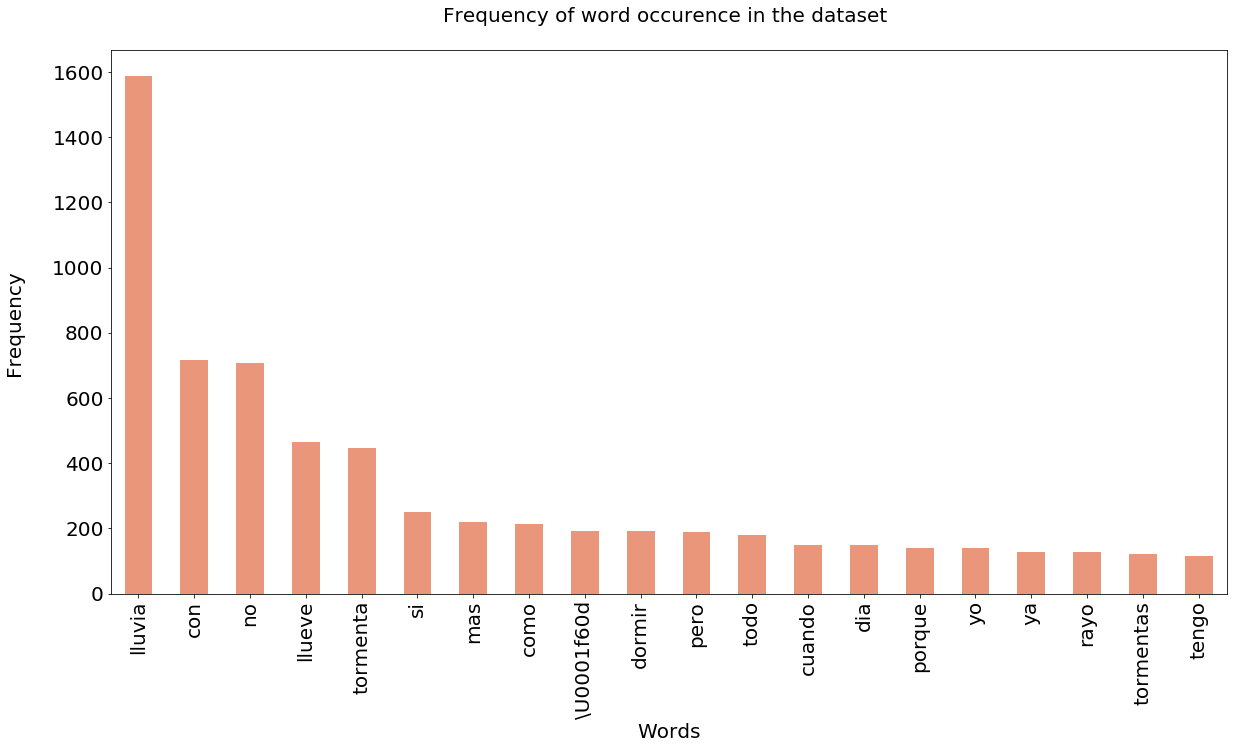

In [15]:
msj_ort = bow(ORT, 'msj_ort')
msj_ort.iloc[0:20].plot(x = 'Diccionario', y = 'Frecuencia', kind = 'bar',figsize=(20,10), fontsize = 20, legend = None, color = "darksalmon")
plt.title('Frequency of word occurence in the dataset \n', fontsize = 20)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('Frequency \n', fontsize = 20)
#plt.xticks(range(0,20), ['lluvia\n(rain)', 'con\n(with)', 'no\n(no)', 'llueve\n(it rains)', 'tormenta\n(storm)', 'si\n(yes)', 'más\n(more)', 'como\n(how)', 'dormir\n(sleep)', 'pero\n(but)', 'todo\n(all)', 'cuando\n(when)', 'día\n(day)', 'porque\n(because)', 'yo\n(me)', 'rayo\n(lightning)', 'ya\n(now)', 'tormentas\n(storms)', 'tengo\n(have)', 'linda\n(beautiful)'], rotation = 45, fontsize = 15)

Text(0,0.5,'Frequency \n')

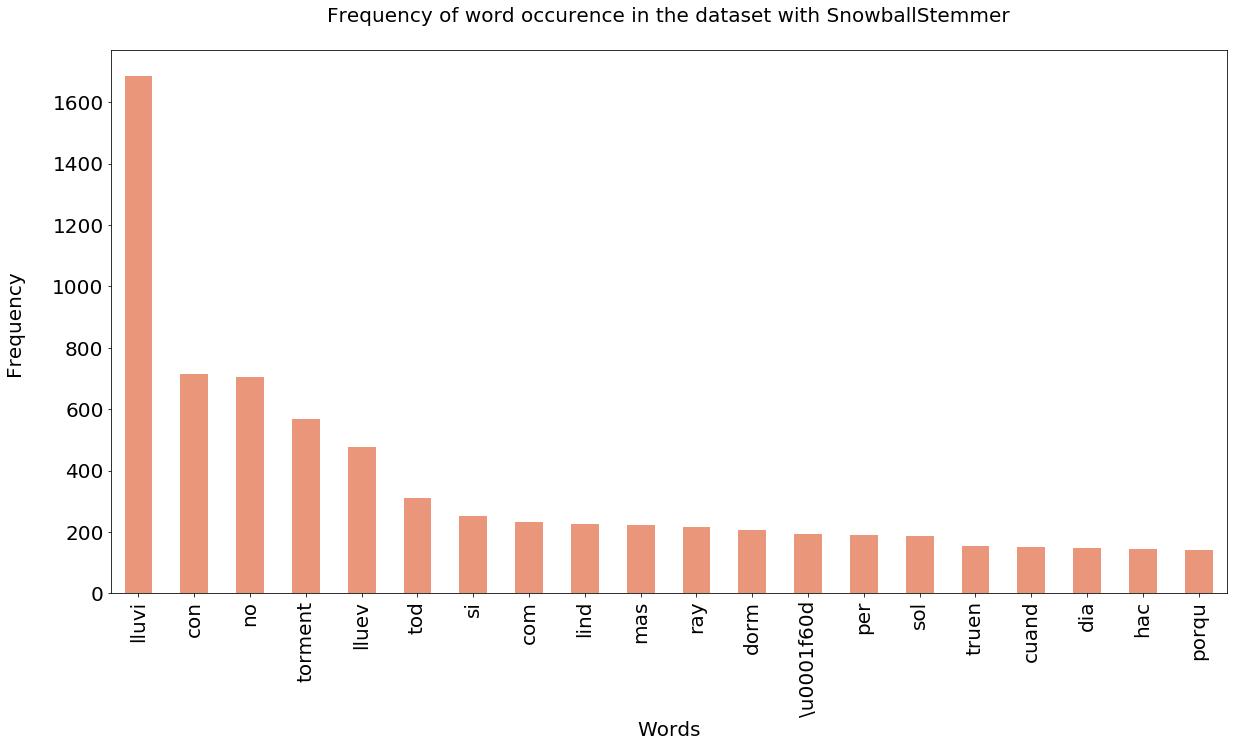

In [16]:
stemm = bow(ORT, 'msj_stemm')
stemm.iloc[0:20].plot(x = 'Diccionario', y = 'Frecuencia', kind = 'bar',figsize=(20,10), fontsize = 20, legend = None, color = "darksalmon")
plt.title('Frequency of word occurence in the dataset with SnowballStemmer\n', fontsize = 20)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('Frequency \n', fontsize = 20)
#plt.xticks(range(0,20), ['lluvia\n(rain)', 'no\n(no)', 'llueve\n(it rains)', 'tormenta\n(storm)', 'si\n(yes)', 'dormir\n(sleep)', 'cuando\n(when)', 'día\n(day)', 'rayo\n(lightning)', 'ya\n(now)', 'tormentas\n(storms)', 'linda\n(beautiful)','tengo\n(have)', 'hoy\n(today)', 'estrellas\n(stars)', 'lindo\n(beautiful)', 'voy\n(go)', 'hay\n(there is)', 'días\n(days)', 'sol\n(sun)' ], rotation = 45, fontsize = 15)

Text(0,0.5,'Frequency \n')

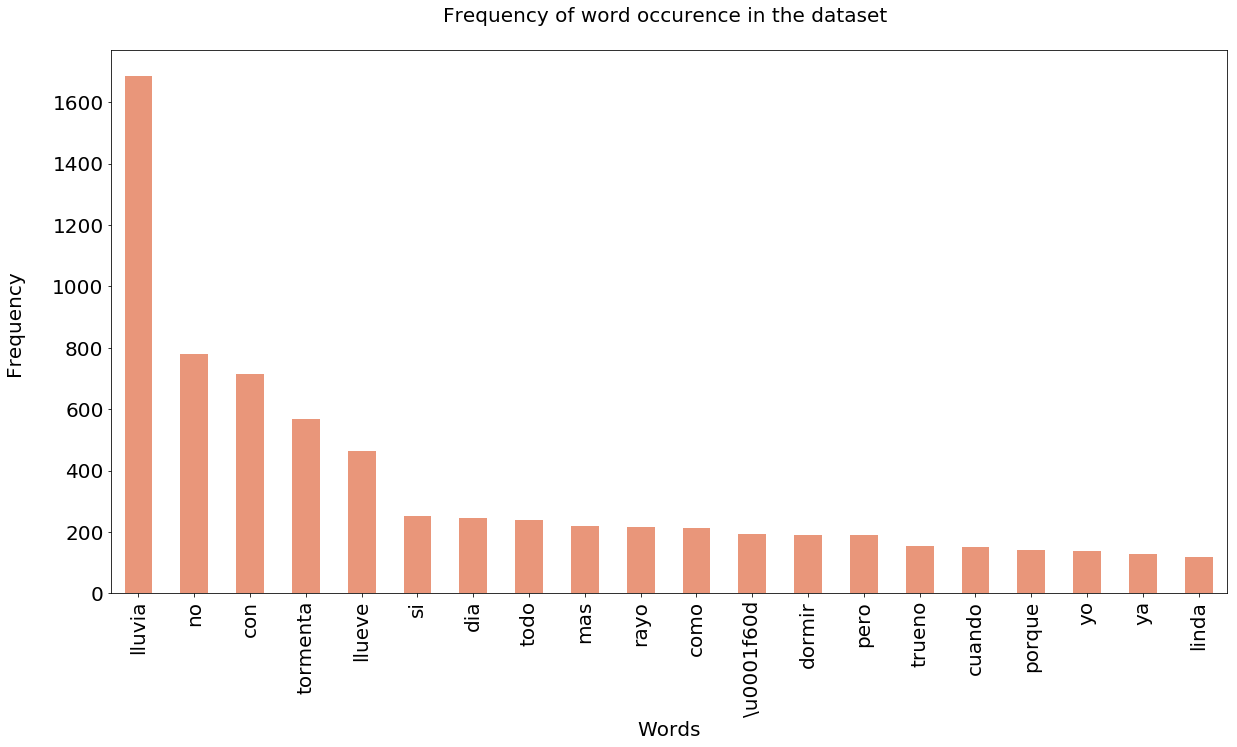

In [17]:
msj_noplural = bow(ORT, 'msj_noplural')
msj_noplural.iloc[0:20].plot(x = 'Diccionario', y = 'Frecuencia', kind = 'bar',figsize=(20,10), fontsize = 20, legend = None, color = "darksalmon")
plt.title('Frequency of word occurence in the dataset \n', fontsize = 20)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('Frequency \n', fontsize = 20)
#plt.xticks(range(0,20), ['lluvia\n(rain)', 'con\n(with)', 'no\n(no)', 'llueve\n(it rains)', 'tormenta\n(storm)', 'si\n(yes)', 'más\n(more)', 'como\n(how)', 'dormir\n(sleep)', 'pero\n(but)', 'todo\n(all)', 'cuando\n(when)', 'día\n(day)', 'porque\n(because)', 'yo\n(me)', 'rayo\n(lightning)', 'ya\n(now)', 'tormentas\n(storms)', 'tengo\n(have)', 'linda\n(beautiful)'], rotation = 45, fontsize = 15)

([<matplotlib.axis.XTick at 0x7f2ff63ba630>,
 <a list of 20 Text xticklabel objects>)

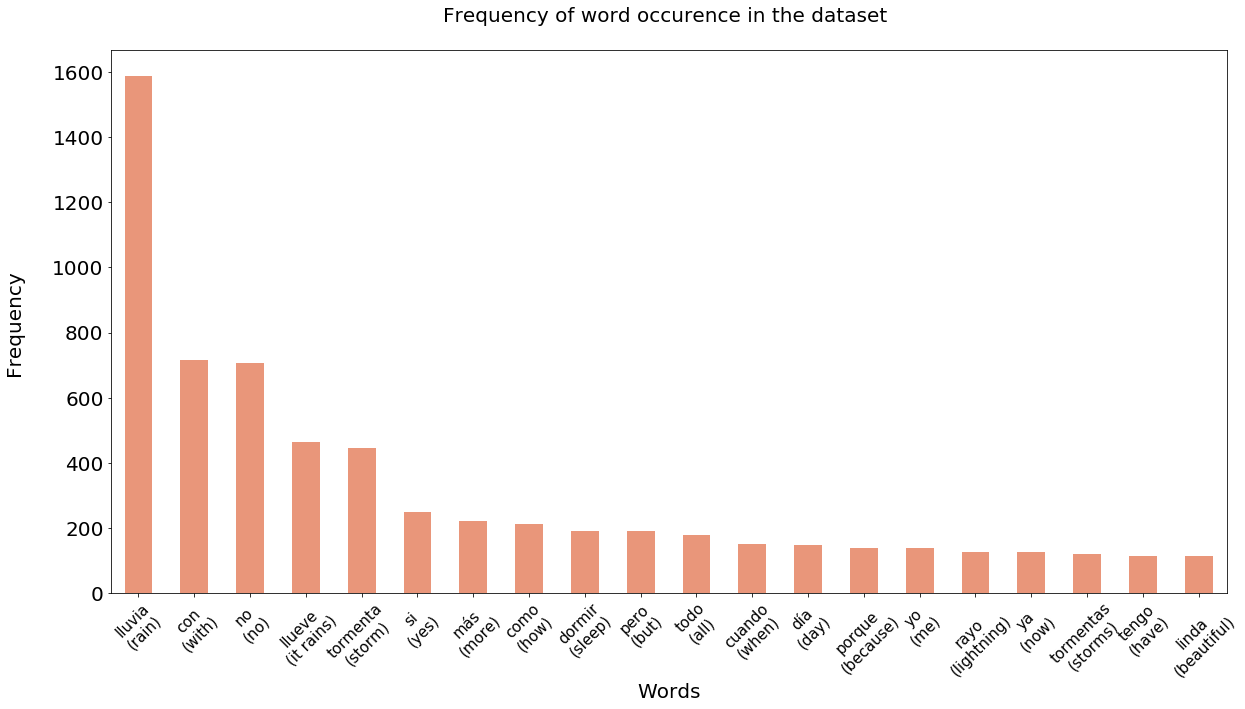

In [18]:
noEmoji = bow(ORT, 'msj_noemoji')
noEmoji.iloc[0:20].plot(x = 'Diccionario', y = 'Frecuencia', kind = 'bar',figsize=(20,10), fontsize = 20, legend = None, color = "darksalmon")
plt.title('Frequency of word occurence in the dataset \n', fontsize = 20)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('Frequency \n', fontsize = 20)
plt.xticks(range(0,20), ['lluvia\n(rain)', 'con\n(with)', 'no\n(no)', 'llueve\n(it rains)', 'tormenta\n(storm)', 'si\n(yes)', 'más\n(more)', 'como\n(how)', 'dormir\n(sleep)', 'pero\n(but)', 'todo\n(all)', 'cuando\n(when)', 'día\n(day)', 'porque\n(because)', 'yo\n(me)', 'rayo\n(lightning)', 'ya\n(now)', 'tormentas\n(storms)', 'tengo\n(have)', 'linda\n(beautiful)'], rotation = 45, fontsize = 15)

([<matplotlib.axis.XTick at 0x7f2ffd2c9208>,
 <a list of 20 Text xticklabel objects>)

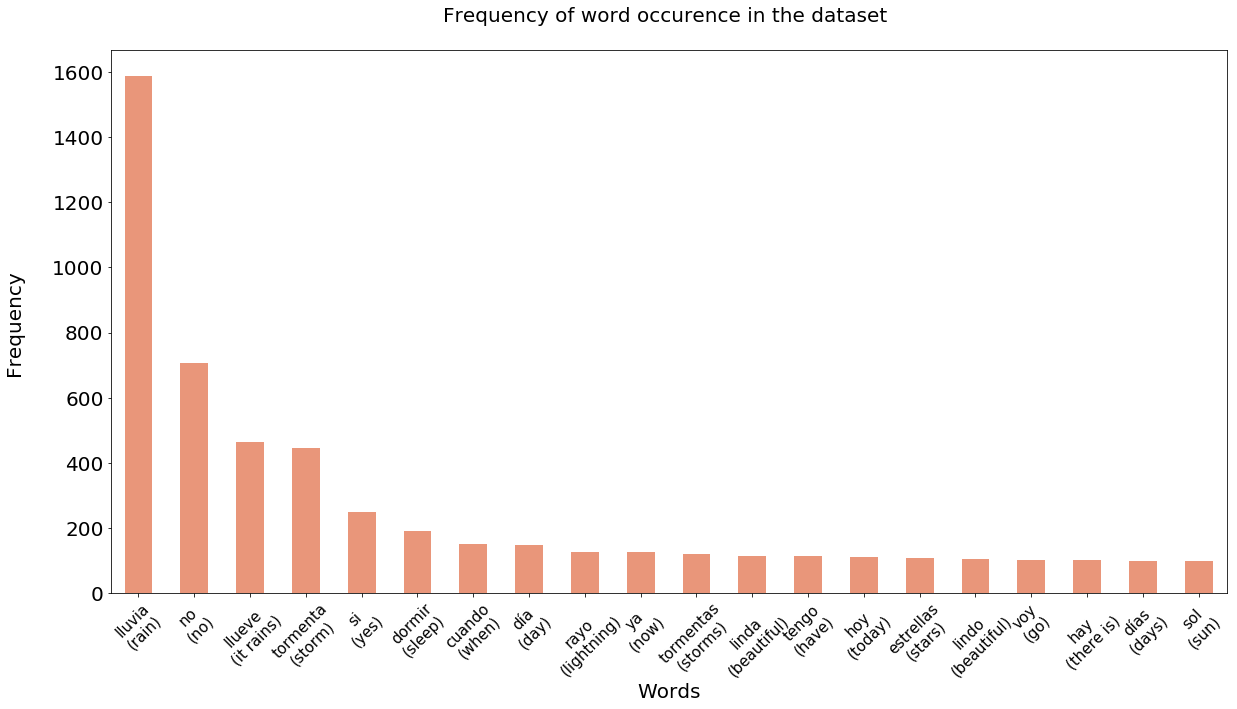

In [19]:
esp = bow(ORT, 'msj_esp')
esp.iloc[0:20].plot(x = 'Diccionario', y = 'Frecuencia', kind = 'bar',figsize=(20,10), fontsize = 20, legend = None, color = "darksalmon")
plt.title('Frequency of word occurence in the dataset \n', fontsize = 20)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('Frequency \n', fontsize = 20)
plt.xticks(range(0,20), ['lluvia\n(rain)', 'no\n(no)', 'llueve\n(it rains)', 'tormenta\n(storm)', 'si\n(yes)', 'dormir\n(sleep)', 'cuando\n(when)', 'día\n(day)', 'rayo\n(lightning)', 'ya\n(now)', 'tormentas\n(storms)', 'linda\n(beautiful)','tengo\n(have)', 'hoy\n(today)', 'estrellas\n(stars)', 'lindo\n(beautiful)', 'voy\n(go)', 'hay\n(there is)', 'días\n(days)', 'sol\n(sun)' ], rotation = 45, fontsize = 15)

([<matplotlib.axis.XTick at 0x7f2ff5832278>,
 <a list of 20 Text xticklabel objects>)

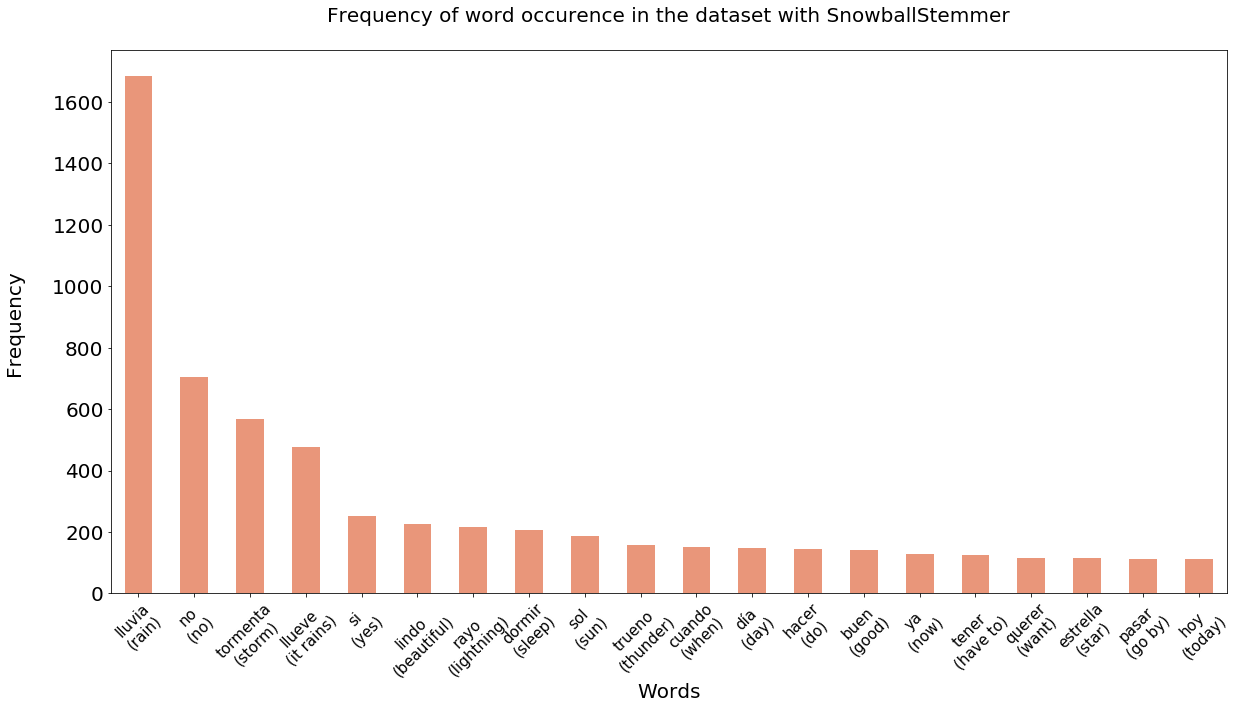

In [20]:
stemmesp = bow(ORT, 'msj_stemmesp')
stemmesp.iloc[0:20].plot(x = 'Diccionario', y = 'Frecuencia', kind = 'bar',figsize=(20,10), fontsize = 20, legend = None, color = "darksalmon")
plt.title('Frequency of word occurence in the dataset with SnowballStemmer\n', fontsize = 20)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('Frequency \n', fontsize = 20)
plt.xticks(range(0,20), ['lluvia\n(rain)', 'no\n(no)','tormenta\n(storm)', 'llueve\n(it rains)', 'si\n(yes)', 'lindo\n(beautiful)', 'rayo\n(lightning)', 'dormir\n(sleep)', 'sol\n(sun)', 'trueno\n(thunder)', 'cuando\n(when)', 'día\n(day)','hacer\n(do)', 'buen\n(good)', 'ya\n(now)', 'tener\n(have to)', 'querer\n(want)', 'estrella\n(star)', 'pasar\n(go by)' , 'hoy\n(today)'], rotation = 45, fontsize = 15)

In [21]:
emoji = bow(ORT, 'msj_emoji')
emoji

,Diccionario,Frecuencia,Num
28,\u2764,86.0,28
11,\U0001f62d,59.0,11
16,\U0001f327,56.0,16
55,\u26c8,39.0,55
7,\u2614,37.0,7
2,\U0001f644,29.0,2
18,\U0001f926,26.0,18
30,\U0001f923,22.0,30
31,\U0001f494,20.0,31
29,\U0001f914,18.0,29


In [22]:
A = ['\\u2764', '\\U0001f62d','\\U0001f327', '\\u26c8', '\\u2614', '\\U0001f644', '\\U0001f926', '\\U0001f923', '\\U0001f494', '\\U0001f914']

In [23]:
archivos = []
# r=root, d=directories, f = files
for r, d, f in os.walk('/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/'):
    for file in f:
          if '.png' in file:
              archivos.append(os.path.join(r, file))
            
archivos

['/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/U0001f62d.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/poo-mark.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/U0001f926.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/U0001f914.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/U0001f327.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/U0001f494.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/poo_plot.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/emoji_plot.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/u2614.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/U0001f923.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/u26c8.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/U0001f644.png',
 '/home/mech/Documents/RELAMPAGO_poster/GEN_DATASET/u2764.png']

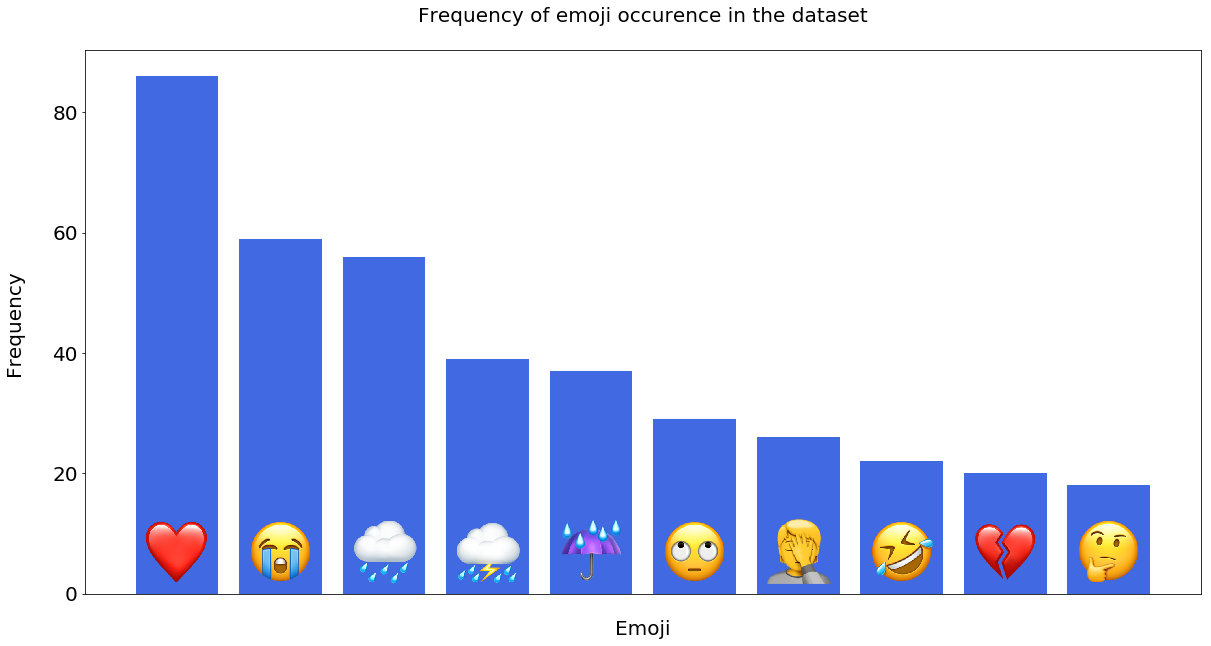

In [24]:
fig, ax = plt.subplots(figsize = [20,10])
plot = ax.bar(emoji['Diccionario'].iloc[0:10], emoji['Frecuencia'].iloc[0:10], color = "royalblue")
fig_width = fig.get_window_extent().width
fig_height = fig.get_window_extent().height
emoji_size = 1300/(fig_width*len(emoji['Diccionario'].iloc[0:10]))
emoji_axs = [None for i in range(len(emoji['Diccionario'].iloc[0:10]))]
plt.title('Frequency of emoji occurence in the dataset\n', fontsize = 20)
plt.xlabel('\nEmoji', fontsize = 20)
plt.ylabel('Frequency \n', fontsize = 20)
plt.yticks(fontsize = 20)
#plt.xticks(fontsize = 20)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

for i in range(len(A)):
    for j in archivos:
        arc = j[50:-4]
        if arc == A[i][1:]: 
            IMG = j
            img = plt.imread(IMG)
            
            loc = ax.transData.transform((i, 7))
            emoji_axs[i] = fig.add_axes([loc[0]/fig_width-emoji_size/2, loc[1]/fig_height-emoji_size/2,
                               emoji_size, emoji_size], anchor='C')
            emoji_axs[i].imshow(img)
            emoji_axs[i].axis("off")
fig.savefig("emoji_plot.png")